In [1]:
import picamera

In [2]:
import os.path
import requests
import numpy as np
import time

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageColor, ImageOps

try:
    import tflite_runtime.interpreter as tflite
except ModuleNotFoundError:
    print("Did you install the TFLite Runtime? https://www.tensorflow.org/lite/guide/python")
    
    
import platform

EDGETPU_SHARED_LIB = 'libedgetpu.so.1'

In [3]:
edgetpu_model_file = 'downloadedModels_mobilenet_float_050_model-stride16_edgetpu.tflite'
tflite_model_file = 'downloadedModels_mobilenet_float_050_model-stride16.tflite'

In [9]:
%%file multipose.py

# Shamelessly based on the Javascript version from:
# https://medium.com/tensorflow/real-time-human-pose-estimation-in-the-browser-with-tensorflow-js-7dd0bc881cd5
# 
# OBS 1: 
# Near to zero efforts were made to optimize the code. 
# Could we get 1000x as in https://youtu.be/nxWginnBklU ??? :)
#

import numpy as np
import scipy.ndimage as ndi
from PIL import ImageDraw, ImageOps

MOBILENET_V1_CONFIG = {
    'architecture': 'MobileNetV1',
    'outputStride': 16,
    'multiplier': 0.75,
    'inputResolution': 257
    }

partNames = [
    'nose', 'leftEye', 'rightEye', 'leftEar', 'rightEar', 'leftShoulder',
    'rightShoulder', 'leftElbow', 'rightElbow', 'leftWrist', 'rightWrist',
    'leftHip', 'rightHip', 'leftKnee', 'rightKnee', 'leftAnkle', 'rightAnkle'
]
NUM_KEYPOINTS = len(partNames)
partIds = {k:i for i,k in enumerate(partNames)}

partIds2Names = {i:k for i,k in enumerate(partNames)}

connectedPartNames = [
        ['leftHip', 'leftShoulder'], ['leftElbow', 'leftShoulder'],
        ['leftElbow', 'leftWrist'], ['leftHip', 'leftKnee'],
        ['leftKnee', 'leftAnkle'], ['rightHip', 'rightShoulder'],
        ['rightElbow', 'rightShoulder'], ['rightElbow', 'rightWrist'],
        ['rightHip', 'rightKnee'], ['rightKnee', 'rightAnkle'],
        ['leftShoulder', 'rightShoulder'], ['leftHip', 'rightHip']
    ]
poseChain = [
        ['nose', 'leftEye'], ['leftEye', 'leftEar'], ['nose', 'rightEye'],
        ['rightEye', 'rightEar'], ['nose', 'leftShoulder'],
        ['leftShoulder', 'leftElbow'], ['leftElbow', 'leftWrist'],
        ['leftShoulder', 'leftHip'], ['leftHip', 'leftKnee'],
        ['leftKnee', 'leftAnkle'], ['nose', 'rightShoulder'],
        ['rightShoulder', 'rightElbow'], ['rightElbow', 'rightWrist'],
        ['rightShoulder', 'rightHip'], ['rightHip', 'rightKnee'],
        ['rightKnee', 'rightAnkle']
    ]

partChannels = [
        'left_face',
        'right_face',
        'right_upper_leg_front',
        'right_lower_leg_back',
        'right_upper_leg_back',
        'left_lower_leg_front',
        'left_upper_leg_front',
        'left_upper_leg_back',
        'left_lower_leg_back',
        'right_feet',
        'right_lower_leg_front',
        'left_feet',
        'torso_front',
        'torso_back',
        'right_upper_arm_front',
        'right_upper_arm_back',
        'right_lower_arm_back',
        'left_lower_arm_front',
        'left_upper_arm_front',
        'left_upper_arm_back',
        'left_lower_arm_back',
        'right_hand',
        'right_lower_arm_front',
        'left_hand'
    ];

parentChildrenTuples = [[partIds[parentJoinName], partIds[childJoinName]] for parentJoinName,childJoinName in poseChain]

parentToChildEdges = [i[1] for i in parentChildrenTuples]

childToParentEdges = [i[0] for i in parentChildrenTuples]

def getOffsetPoint(y, x, keypoint, offsets):
    return {
        'y': offsets[y, x, keypoint],
        'x': offsets[y, x, keypoint + NUM_KEYPOINTS]
    }

def getImageCoords(part, outputStride, offsets):
#     heatmapY = part['heatmapY']
#     heatmapX = part['heatmapX']
#     keypoint = part['id']
#     _a = getOffsetPoint(heatmapY, heatmapX, keypoint, offsets)
#     y = _a['y']
#     x = _a['x']
    return {
        'x': part['heatmapX'] * outputStride + offsets[part['heatmapY'], part['heatmapX'], part['id'] + NUM_KEYPOINTS],
        'y': part['heatmapY'] * outputStride + offsets[part['heatmapY'], part['heatmapX'], part['id']]
    }


def squaredDistance(y1, x1, y2, x2):
    return (x2 - x1)**2 + (y2 - y1)**2
    
def getDisplacement(edgeId, point, displacements):
    numEdges = int(displacements.shape[2] / 2)
    return {
        'y': displacements[point['y'], point['x'], edgeId],
        'x': displacements[point['y'], point['x'], numEdges + edgeId]
    }

def addVectors(a, b):
    return { 'x': a['x'] + b['x'], 'y': a['y'] + b['y'] };

def clamp(n, smallest, largest): 
    return int(max(smallest, min(n, largest)))

def getStridedIndexNearPoint(point, outputStride, height, width):
    return {
        'y': clamp(point['y'] / outputStride, 0, height - 1),
        'x': clamp(point['x'] / outputStride, 0, width - 1)
    }

# from https://github.com/rwightman/posenet-python
def buildPartWithScoreQueue(scoreThreshold, kLocalMaximumRadius=1, scores=None):
    parts = []
    num_keypoints = scores.shape[2]
    lmd = 2 * kLocalMaximumRadius + 1

    # NOTE it seems faster to iterate over the keypoints and perform maximum_filter
    # on each subarray vs doing the op on the full score array with size=(lmd, lmd, 1)
    for keypoint_id in range(num_keypoints):
        kp_scores = scores[:, :, keypoint_id].copy()
        kp_scores[kp_scores < scoreThreshold] = 0.
        
        max_vals = ndi.maximum_filter(kp_scores, size=lmd, mode='constant')
        
        max_loc = np.logical_and(kp_scores == max_vals, kp_scores > 0)
        max_loc_idx = max_loc.nonzero()
        for y, x in zip(*max_loc_idx):
            parts.append({'score': scores[y, x, keypoint_id], 
                      'part': {'heatmapY': y, 'heatmapX': x, 'id': keypoint_id }
                      })

    return parts



def traverseToTargetKeypoint(edgeId, sourceKeypoint, targetKeypointId, scoresBuffer, offsets, outputStride, displacements, offsetRefineStep=None):
    if (offsetRefineStep == None):  offsetRefineStep = 2
    height = scoresBuffer.shape[0]
    width = scoresBuffer.shape[1];
    sourceKeypointIndices = getStridedIndexNearPoint(sourceKeypoint['position'], outputStride, height, width)
    displacement = getDisplacement(edgeId, sourceKeypointIndices, displacements)
    displacedPoint = addVectors(sourceKeypoint['position'], displacement)
    targetKeypoint = displacedPoint
    for i in range(offsetRefineStep):
        targetKeypointIndices = getStridedIndexNearPoint(targetKeypoint, outputStride, height, width)
        offsetPoint = getOffsetPoint(targetKeypointIndices['y'], targetKeypointIndices['x'], targetKeypointId, offsets)
        targetKeypoint = addVectors({
            'x': targetKeypointIndices['x'] * outputStride,
            'y': targetKeypointIndices['y'] * outputStride
        }, { 'x': offsetPoint['x'], 'y': offsetPoint['y'] })
    targetKeyPointIndices = getStridedIndexNearPoint(targetKeypoint, outputStride, height, width)
    score = scoresBuffer[targetKeyPointIndices['y'], targetKeyPointIndices['x'], targetKeypointId]
    return { 'position': targetKeypoint, 'score': score }


def decodePose(root, rootImageCoords, scores, offsets, outputStride, displacementsFwd, displacementsBwd):
    numParts = scores.shape[2]
    numEdges = len(parentToChildEdges);
    instanceKeypoints = dict(zip(partNames,[None]*numParts))
    rootPart = root['part']
    rootScore = root['score']
    rootPoint = rootImageCoords #getImageCoords(rootPart, outputStride, offsets)
    instanceKeypoints[partNames[rootPart['id']]] = {
        'score': rootScore,
        'position': rootPoint}

    for edge in range(numEdges)[::-1]:
        sourceKeypointId = partIds2Names[parentToChildEdges[edge]]
        targetKeypointId = partIds2Names[childToParentEdges[edge]]
        if (instanceKeypoints[sourceKeypointId] and (not instanceKeypoints[targetKeypointId])):
            instanceKeypoints[targetKeypointId] = traverseToTargetKeypoint(edge, instanceKeypoints[sourceKeypointId], partIds[targetKeypointId], scores, offsets, outputStride, displacementsBwd)
  
    for edge in range(numEdges):
        sourceKeypointId = partIds2Names[childToParentEdges[edge]]
        targetKeypointId = partIds2Names[parentToChildEdges[edge]]
        if (instanceKeypoints[sourceKeypointId] and (not instanceKeypoints[targetKeypointId])):
            instanceKeypoints[targetKeypointId] = traverseToTargetKeypoint(edge, instanceKeypoints[sourceKeypointId], partIds[targetKeypointId], scores, offsets, outputStride, displacementsFwd)
    
    return instanceKeypoints

def withinNmsRadiusOfCorrespondingPoint(poses, squaredNmsRadius, rootImageCoords, keypointId):
    x = rootImageCoords['x']
    y = rootImageCoords['y']

    for pose in poses:
      keypoints = pose['keypoints']
      correspondingKeypoint = keypoints[partIds2Names[keypointId]]['position']
      if squaredDistance(y, x, correspondingKeypoint['y'], correspondingKeypoint['x']) <= squaredNmsRadius:
        return True
    return False

def getInstanceScore(existingPoses, squaredNmsRadius, instanceKeypoints):
    notOverlappedKeypointScores = 0.0
    for keypointId,ik in enumerate(instanceKeypoints.values()):
        position = ik['position']
        score = ik['score']
        # if (not withinNmsRadiusOfCorrespondingPoint(existingPoses, squaredNmsRadius, position, keypointId)):
        notOverlappedKeypointScores += score

    return notOverlappedKeypointScores/len(instanceKeypoints)

def _sigmoid(z):
  return 1/(1 + np.exp(-z))

def decodeMultiplePoses(scoresBuffer, offsetsBuffer, displacementsFwdBuffer, displacementsBwdBuffer, 
                        outputStride=16, maxPoseDetections=5, scoreThreshold=None, nmsRadius=None, kLocalMaximumRadius=1):
  return _decodeMultiplePoses(_sigmoid(np.asarray(scoresBuffer)), np.asarray(offsetsBuffer), np.asarray(displacementsFwdBuffer), np.asarray(displacementsBwdBuffer), 
                              outputStride, maxPoseDetections, scoreThreshold, nmsRadius, kLocalMaximumRadius)
def _decodeMultiplePoses(scoresBuffer, offsetsBuffer, displacementsFwdBuffer, displacementsBwdBuffer, outputStride, 
                         maxPoseDetections, scoreThreshold, nmsRadius, kLocalMaximumRadius):
  if scoreThreshold == None: scoreThreshold = 0.5
  if nmsRadius == None: nmsRadius = 20
  poses = []
  queue = buildPartWithScoreQueue(scoreThreshold, kLocalMaximumRadius, scoresBuffer)
  squaredNmsRadius = nmsRadius * nmsRadius;
  while (len(poses) < maxPoseDetections) and len(queue):
    root = queue.pop()
    rootImageCoords = getImageCoords(root['part'], outputStride, offsetsBuffer)
    if (withinNmsRadiusOfCorrespondingPoint(poses, squaredNmsRadius, rootImageCoords, root['part']['id'])):
      continue
    keypoints = decodePose(root, rootImageCoords, scoresBuffer, offsetsBuffer, outputStride, displacementsFwdBuffer, displacementsBwdBuffer)
    score = getInstanceScore(poses, squaredNmsRadius, keypoints)
    poses.append({ 'keypoints': keypoints, 'score': score })
  return poses

def draw_pose(pose, img, input_shape, threshold=0.5, marker_color='green', color='yellow', marker_size=5, thickness=2):
    # Resize and pad if necessary, the same way done for the inference
    img = ImageOps.pad(img, input_shape)
    draw = ImageDraw.Draw(img)

    for p1, p2 in poseChain:
        if (pose[p1]['score'] < threshold) or (pose[p2]['score'] < threshold): continue
        draw.line((pose[p1]['position']['x'], pose[p1]['position']['y'], pose[p2]['position']['x'], pose[p2]['position']['y']), fill=color, width=thickness)

    for label, keypoint in pose.items():
      if keypoint['score'] < threshold: continue
      draw.ellipse((int(keypoint['position']['x']-marker_size/2), 
                    int(keypoint['position']['y']-marker_size/2), 
                    int(keypoint['position']['x']+marker_size/2), 
                    int(keypoint['position']['y']+marker_size/2)), fill=marker_color)
      
    return img

Overwriting multipose.py


In [2]:
# %load_ext autoreload
# %autoreload 2

In [10]:
from multipose import *

In [11]:
frameWidth = 256
frameHeight = 256
frameRate = 20
contrast = 40


output = np.zeros((257,257,3), dtype=np.uint8)
tmp_output = np.empty((frameWidth, frameHeight, 3), dtype=np.uint8)

In [12]:
with picamera.PiCamera() as camera:
    camera.resolution = (frameWidth, frameHeight)
    #camera.framerate = frameRate
    camera.rotation = 0
    camera.capture(tmp_output, 'rgb')
    
output.fill(0)
output[:frameWidth, :frameHeight, :] = tmp_output

In [13]:
img = Image.fromarray(output)

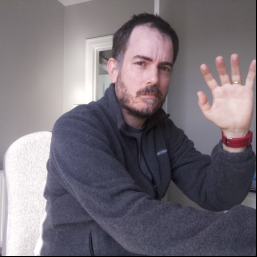

In [35]:
img

In [36]:
#
# CPU
#
tflite_interpreter = tflite.Interpreter(model_path=tflite_model_file)
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("INPUT:\n", input_details)
print("OUTPUT:\n", output_details)

INPUT:
 [{'name': 'sub_2_int8', 'index': 0, 'shape': array([  1, 257, 257,   3]), 'shape_signature': array([  1, 257, 257,   3]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.01097053661942482, 2), 'quantization_parameters': {'scales': array([0.01097054], dtype=float32), 'zero_points': array([2]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
OUTPUT:
 [{'name': 'MobilenetV1/displacement_bwd_2/BiasAdd_int8', 'index': 90, 'shape': array([ 1, 17, 17, 32]), 'shape_signature': array([ 1, 17, 17, 32]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.6964774131774902, 50), 'quantization_parameters': {'scales': array([0.6964774], dtype=float32), 'zero_points': array([50]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'MobilenetV1/displacement_fwd_2/BiasAdd_int8', 'index': 91, 'shape': array([ 1, 17, 17, 32]), 'shape_signature': array([ 1, 17, 17, 32]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.5838690996170044, -42), 'quantization_parameters': {'scale

In [44]:
#
# EdgeTPU Accelerator
#
device = [] # I have only one USB accelerator...
tflite_interpreter = tflite.Interpreter(model_path=edgetpu_model_file, 
                                        experimental_delegates=[tflite.load_delegate(EDGETPU_SHARED_LIB,{'device': device[0]} if device else {})])
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("INPUT:\n", input_details)
print("OUTPUT:\n", output_details)

INPUT:
 [{'name': 'sub_2_int8', 'index': 0, 'shape': array([  1, 257, 257,   3]), 'shape_signature': array([  1, 257, 257,   3]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.01097053661942482, 2), 'quantization_parameters': {'scales': array([0.01097054], dtype=float32), 'zero_points': array([2]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
OUTPUT:
 [{'name': 'MobilenetV1/displacement_bwd_2/BiasAdd_int8', 'index': 1, 'shape': array([ 1, 17, 17, 32]), 'shape_signature': array([ 1, 17, 17, 32]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.6964774131774902, 50), 'quantization_parameters': {'scales': array([0.6964774], dtype=float32), 'zero_points': array([50]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'MobilenetV1/displacement_fwd_2/BiasAdd_int8', 'index': 2, 'shape': array([ 1, 17, 17, 32]), 'shape_signature': array([ 1, 17, 17, 32]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.5838690996170044, -42), 'quantization_parameters': {'scales'

In [16]:
preprocessed_img = np.expand_dims(((np.asarray(img)[...,:3]).astype('float32')-127).astype('int8'), axis=0)

In [17]:
%%time
tflite_interpreter.set_tensor(input_details[0]['index'], 
                              preprocessed_img
                              )
tflite_interpreter.invoke()

CPU times: user 67.9 ms, sys: 21.8 ms, total: 89.7 ms
Wall time: 121 ms


In [48]:
formated_outputs = {"heatmap": {}, 'offset': {}, 'displacement_fwd': {}, 'displacement_bwd': {}}

for o in output_details:
    for name in formated_outputs.keys():
        if name in o['name']:
            # https://www.tensorflow.org/lite/performance/quantization_spec
            zero_point = o['quantization'][1]
            scale = o['quantization'][0]
            formated_outputs[name] = (tflite_interpreter.get_tensor(o['index'])[0].astype(float)-zero_point)*scale
            print(name, zero_point, scale)

displacement_bwd 50 0.6964774131774902
displacement_fwd -42 0.5838690996170044
heatmap 42 0.07184595614671707
offset 8 0.25506776571273804


In [49]:
# %%prun -s cumulative
poses = decodeMultiplePoses(formated_outputs['heatmap'], 
                            formated_outputs['offset'], 
                            formated_outputs['displacement_fwd'], 
                            formated_outputs['displacement_bwd'])

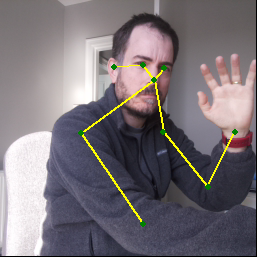

0.5076844933180069


In [54]:
for pose in poses:
    if pose['score'] >= 0.5:
        display(draw_pose(pose['keypoints'], img.copy(), input_shape=(257,257), threshold=0.3))
        print(pose['score'])

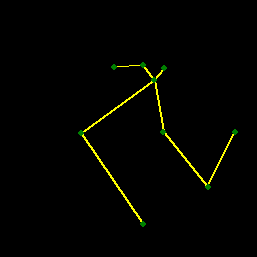

0.5076844933180069


In [56]:
for pose in poses:
    if pose['score'] >= 0.5:
        display(draw_pose(pose['keypoints'], Image.new('RGB', (257,257)), input_shape=(257,257), threshold=0.3))
        print(pose['score'])

# Let's build a script to run from command line!

In [15]:
%%file test_edgetpu_multiposes.py
import numpy as np

from multipose import decodeMultiplePoses

import picamera

try:
    import tflite_runtime.interpreter as tflite
except ModuleNotFoundError:
    print("Did you install the TFLite Runtime? https://www.tensorflow.org/lite/guide/python")
    
    
import platform

EDGETPU_SHARED_LIB = 'libedgetpu.so.1'  

edgetpu_model_file = 'downloadedModels_mobilenet_float_050_model-stride16_edgetpu.tflite'
    
import io
import time
import numpy as np


class EdgeTPU_MultiPoses(io.IOBase):
    '''
    Capturing Image from a Raspicam (V2.1)
    '''
    def __init__(self, frameWidth=257, frameHeight=257, scoreThreshold=0.5, debug = False):
        # Init the stuff we are inheriting from
        super(__class__, self).__init__()

        self.debug = debug

        # Set video frame parameters
        self.frameWidth = frameWidth
        self.frameHeight = frameHeight
        
        self.scoreThreshold = scoreThreshold
        self.poses = []

        self.prev_time = time.time()
        
        #
        # EdgeTPU Accelerator
        #
        device = [] # I have only one USB accelerator...
        self.tflite_interpreter = tflite.Interpreter(model_path=edgetpu_model_file, 
                                                experimental_delegates=[tflite.load_delegate(EDGETPU_SHARED_LIB,{'device': device[0]} if device else {})])
        self.tflite_interpreter.allocate_tensors()

        self.input_details = self.tflite_interpreter.get_input_details()
        self.output_details = self.tflite_interpreter.get_output_details()
        
        
        # Picamera doesn't like 257x257, so the image will be padded
        self.final_output = np.zeros((257,257,3), dtype=np.uint8)
        self.tmp_output = np.empty((frameWidth, frameHeight, 3), dtype=np.uint8)

        preprocessed_img = np.expand_dims((self.final_output.astype('float32')-127).astype('int8'), axis=0)

        # The first time is slower, so let's do it here!
        self.tflite_interpreter.set_tensor(self.input_details[0]['index'], preprocessed_img)
        self.tflite_interpreter.invoke()



    def writable(self):
        '''
        To be a nice file, you must have this method
        '''
        return True

    def write(self, b):
        '''
        Here is where the image data is received and made available at self.output
        '''

        try:
            # b is the numpy array of the image, 3 bytes of color depth
            img = np.reshape(np.frombuffer(b, dtype=np.uint8), (self.frameHeight, self.frameWidth, 3))
            
            self.get_poses(img)

            if self.debug:
                print(f"EdgeTPU_MultiPoses - Poses found: {len(self.poses)}")
                print("EdgeTPU_MultiPoses - Pose scores:", [f"{(i['score']):2.2f}" for i in self.poses])
                print("EdgeTPU_MultiPoses - Running at {:2.2f} Hz".format(1/(time.time()-self.prev_time)))

            self.prev_time = time.time()

        except Exception as e:
            print("ImgCap error: {}".format(e))
        finally:
            return len(b)
        
    def get_poses(self, img):        
        self.final_output.fill(0)
        self.final_output[:self.frameWidth, :self.frameHeight, :] = img

        preprocessed_img = np.expand_dims((self.final_output.astype('float32')-127).astype('int8'), axis=0)
        # The first time is slower
        self.tflite_interpreter.set_tensor(self.input_details[0]['index'], preprocessed_img)
        self.tflite_interpreter.invoke()


        formated_outputs = {"heatmap": {}, 'offset': {}, 'displacement_fwd': {}, 'displacement_bwd': {}}
        for o in self.output_details:
            for name in formated_outputs.keys():
                if name in o['name']:
                    # https://www.tensorflow.org/lite/performance/quantization_spec
                    zero_point = o['quantization'][1]
                    scale = o['quantization'][0]
                    formated_outputs[name] = (self.tflite_interpreter.get_tensor(o['index'])[0].astype(float)-zero_point)*scale

        self.poses = decodeMultiplePoses(formated_outputs['heatmap'], 
                                         formated_outputs['offset'], 
                                         formated_outputs['displacement_fwd'], 
                                         formated_outputs['displacement_bwd'],
                                         scoreThreshold=self.scoreThreshold)


if __name__ == "__main__":
    frameWidth = 256 
    frameHeight = 256
    frameRate = 20

    # Set the picamera parametertaob
    camera = picamera.PiCamera()
    camera.resolution = (frameWidth, frameHeight)
    camera.framerate = frameRate

    # Start the video process
    with EdgeTPU_MultiPoses(frameWidth, frameHeight, debug=True) as img:
        camera.start_recording(img, format='rgb', splitter_port = 1)
        try:
            while True:
                camera.wait_recording(timeout=1/frameRate) # using timeout=0, default, it'll return immediately  

        except KeyboardInterrupt:
            pass
        finally:
            camera.stop_recording(splitter_port = 1)

Overwriting test_edgetpu_multiposes.py
